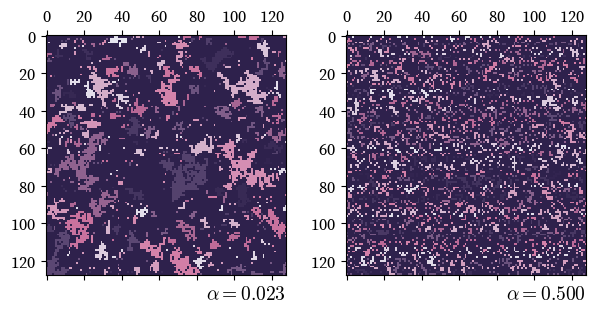

In [1]:
#| code-fold: true
import warnings

warnings.filterwarnings("ignore")
import os

os.chdir("/project/persistent-exclusion-process")

import matplotlib.pyplot as plt
import cmcrameri
import h5py
import numpy as np
from scipy import ndimage

from src.utils import get_cluster_labels, get_ds_iters
from src.plot_utils import get_plot_configs

plot_configs = get_plot_configs()
plot_configs["xtick.labelsize"] = 12
plot_configs["ytick.labelsize"] = 12
plt.rcParams.update(plot_configs)


def plot_labelled_cluster(axis, file, sshot_idx):
    cmap_label = plt.get_cmap(name="cmc.actonS")
    labelled, _ = get_cluster_labels(file, sshot_idx)
    axis.matshow(labelled, cmap=cmap_label)
    return axis


sshot_idx = -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
ax1 = plot_labelled_cluster(ax1, "no_roll_data/dataset_tumble_0.023_0.25.h5", sshot_idx)
ax1.text(
    y=-0.1,
    x=1,
    transform=ax1.transAxes,
    ha="right",
    s=r"$\alpha = 0.023$",
)
ax2 = plot_labelled_cluster(ax2, "no_roll_data/dataset_tumble_0.500_0.25.h5", sshot_idx)
ax2.text(
    y=-0.1,
    x=1,
    transform=ax2.transAxes,
    ha="right",
    s=r"$\alpha = 0.500$",
)
plt.show()
fig.savefig("plots/labelling_demo.pdf")

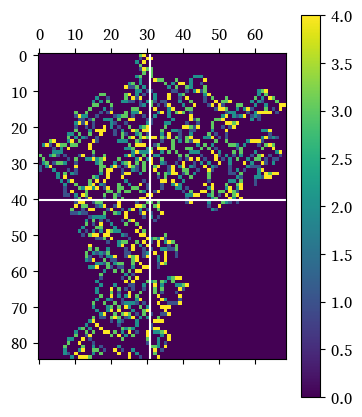

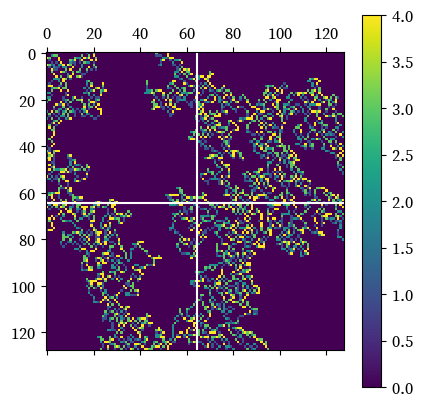

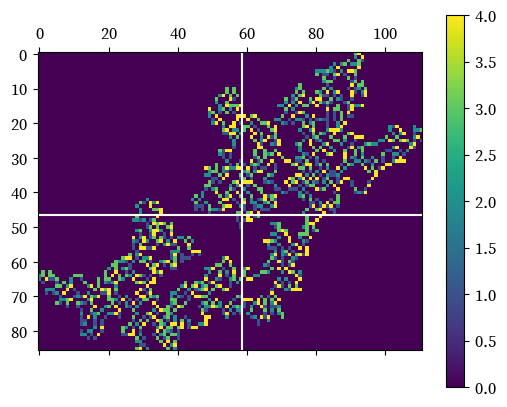

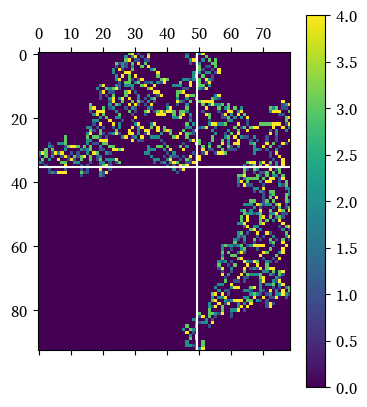

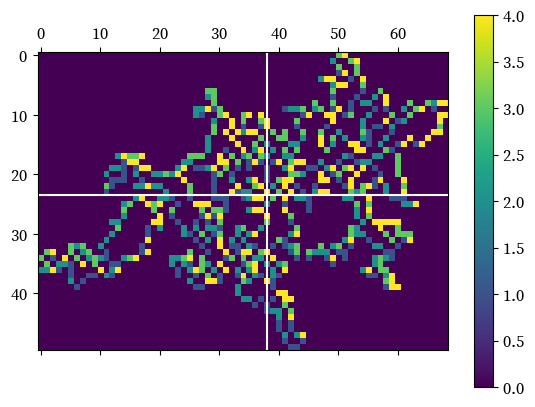

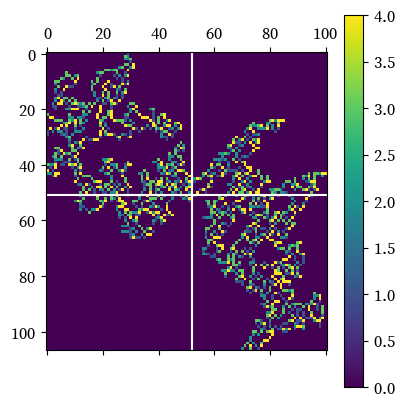

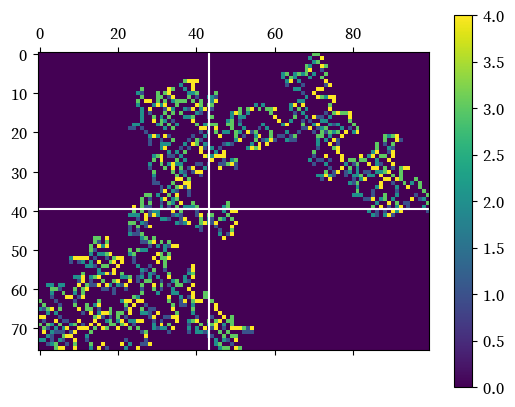

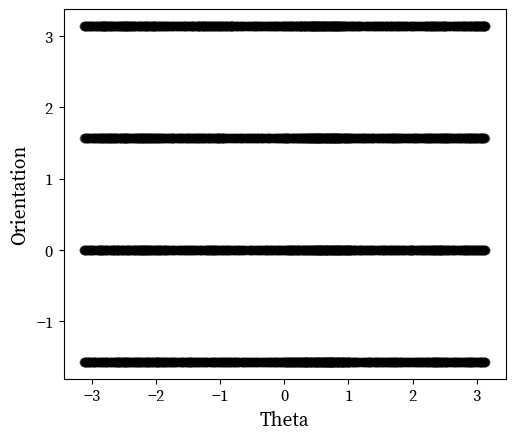

In [2]:
#| code-fold: true
def get_biggest_cluster(img):
    labelled, _ = ndimage.label(img, structure=kernel)
    lb = labelled.flatten()
    cluster_sizes = np.bincount(lb)[1:]
    biggest_cluster_id = np.argmax(cluster_sizes)
    loc = ndimage.find_objects(labelled)[biggest_cluster_id]
    labelled_crop = labelled[loc]
    img_crop = img[loc]
    labelled_crop[labelled_crop != biggest_cluster_id+1] = 0
    labelled_crop[labelled_crop == biggest_cluster_id+1] = 1
    img_crop *= labelled_crop
    return img_crop, ndimage.center_of_mass(labelled_crop)

def get_edges(img):
    img_threshold = np.zeros_like(img)
    img_threshold[img > 0] = 1
    edges = ndimage.laplace(img_threshold)
    edges[edges > -1] = 0
    edges[edges != 0] = 1
    edges *= img
    return edges

def map_ori(ori):
    ori_mapped = np.zeros_like(ori, dtype=np.float_)
    ori_mapped[ori == 1] = np.pi
    ori_mapped[ori == 2] = np.pi/2
    ori_mapped[ori == 3] = 0
    ori_mapped[ori == 4] = -np.pi/2
    return ori_mapped


# 0: y, 1: x
def get_ori_and_loc(edges,com):
    positions = edges.nonzero()
    edges_ori = map_ori(edges[positions[0],positions[1]])
    edges_loc = np.arctan2((com[0]-positions[0]),(positions[1]-com[1]))

    # CHECK CODE
    # colors = ListedColormap(["k", "r", "yellow", "g", "b"])
    # edges[edges == 0] = -4
    # edges[positions[0],positions[1]] = edges_loc
    plt.matshow(edges)
    plt.colorbar()
    plt.axvline(com[1], c='w')
    plt.axhline(com[0], c='w')

    return edges_ori, edges_loc

hf = h5py.File(f"no_roll_data/dataset_tumble_0.034_0.5.h5", "r")
iters = get_ds_iters(hf.keys())
kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
oris, locs = [], []
for val in range(10,50,5):
    img = hf[f"conf_{iters[val]}"]
    img_crop, com = get_biggest_cluster(img)
    edges = get_edges(img_crop)
    ori, loc = get_ori_and_loc(edges,com)
    oris.append(ori)
    locs.append(loc)
oris = np.concatenate(oris)
locs = np.concatenate(locs)
plt.clf()
plt.xlabel("Theta")
plt.ylabel("Orientation")
plt.scatter(locs, oris, alpha=0.1, c='k')

In [4]:
#| code-fold: true

top_half = np.bincount(np.split(img_crop, 2)[0].flatten())[1:]
bottom_half = np.bincount(np.split(img_cropped, 2)[1].flatten())[1:]
left_half = np.bincount(np.split(img_cropd, 2, 1)[0].flatten())[1:]
right_half = np.bincount(np.split(img_croped, 2, 1)[1].flatten())[1:]

ori = {1: "up", 2: "right", 3: "down", 4: "left"}


def check(half, o):
    print(ori[o])
    print(f"{half[o-1]/np.sum(half):.3f}", ori[o])
    print()


check(top_half, 1)
check(bottom_half, 3)
check(left_half, 4)
check(right_half, 2)

ValueError: array split does not result in an equal division

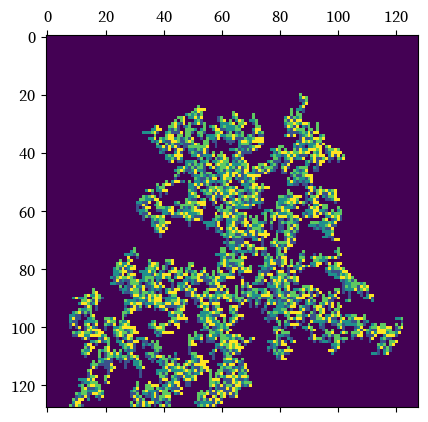

In [6]:
#| code-fold: true

hf = h5py.File("no_roll_data/dataset_tumble_0.016_0.5.h5", "r")
iters = get_ds_iters(hf.keys())
kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
img = hf[f"conf_{iters[-1]}"]
labelled, _ = ndimage.label(img, structure=kernel)
lb = labelled.flatten()
cluster_sizes = np.bincount(lb)[1:]
biggest_cluster_id = np.argmax(cluster_sizes)+1
not_c = labelled==biggest_cluster_id
biggest_only = img*not_c

plt.matshow(biggest_only)